In [ ]:
ximport pandas as pd
import numpy as np
import xgboost as xgb
from google.colab import drive
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
import warnings
from sklearn.exceptions import ConvergenceWarning
from imblearn.over_sampling import RandomOverSampler
from imblearn.over_sampling import SMOTE

drive.mount('/content/drive')




Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# LOAD DATA AND MERGING

In [ ]:
# read NHANES data: Vitamin A, Vitamin E & Carotenoids 2005-2006
derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')
# Dermatology_questionaire
dermatology_questionaire = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/dermatology_questionaire.XPT')
# Alcohol
alcohol = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/alcohol.XPT')
# demo_2003
demo_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/demo_2003.XPT')
# body_measure
body_measure = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/body_measure.XPT')
# Vitimin_ace
vitamin_ace = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/vitamin_ace.XPT')
# use_of_supplements
use_of_supplements = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/use_of_supplements.XPT')
# smoking
smoking = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/smoking.XPT')
# vitimin_d
vitimin_d = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/vitimin_d.XPT')
# CRP
CRP = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/CRP.XPT')
# Supplement_count
supplement_count  = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/supplement_count.XPT')
# physical_activity
physical_activity = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/physical_activity.XPT')
# SMQMEC_C  smoke
SMQMEC_C = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/SMQMEC_C.XPT')
# immunization
immunization = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/immunization.XPT')

<ipython-input-2-42d5dd1f5c0a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')
<ipython-input-2-42d5dd1f5c0a>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  derm_2003 = pd.read_sas('/content/drive/MyDrive/Capstone/derm_data/derm_2003.XPT')


In [ ]:
derm_joined = pd.merge(dermatology_questionaire,derm_2003, on = 'SEQN', how = 'left')
df = pd.merge(derm_joined, demo_2003, on = 'SEQN', how = 'left')
df = pd.merge(df, alcohol, on = 'SEQN', how = 'left')
df = pd.merge(df, body_measure, on = 'SEQN', how = 'left')
df = pd.merge(df, vitamin_ace, on = 'SEQN', how = 'left')
df = pd.merge(df, smoking, on = 'SEQN', how = 'left')
df = pd.merge(df, vitimin_d, on = 'SEQN', how = 'left')
df = pd.merge(df, CRP, on = 'SEQN', how = 'left')
df = pd.merge(df, supplement_count, on = 'SEQN', how = 'left')
#df = pd.merge(df, physical_activity, on = 'SEQN', how = 'left')
df = pd.merge(df, SMQMEC_C, on = 'SEQN', how = 'left')
df = pd.merge(df, immunization, on = 'SEQN', how = 'left')
#df = pd.merge(df, use_of_supplements, on = 'SEQN', how = 'left')

In [ ]:
df['Psoriasis'] = 0
df.loc[(df['DEQ053'] == 1) |
                (df['DED2PSDX'] == 1) |
                (df['DED6PSDX'] == 1) |
                (df['DED1PSDX'] == 1), 'Psoriasis'] = 1

In [ ]:
df_subset = df[['Psoriasis','DED011','DEQ034D','DEQ038G','DED038Q','DEQ055','DEQ057','ALQ101','ALQ120Q','ALQ130','ALQ140Q','ALQ140U','ALQ150','BMXBMI','BMXWAIST','BMXHT','BMXTHICR','RIAGENDR','RIDAGEEX','RIDRETH1','RIDAGEMN','DMDMARTL','INDFMINC','INDHHINC','INDFMPIR','LBDVIDMS','SMQ620','SMQ710','SMQ020','SMQ720','IMD010','IMQ020','IMQ030','DSD010','DSDCOUNT','LBXCRP']]

In [ ]:
#'DSDSUPID','DSDSUPP','DSD103','DSD122Q'
print(df_subset.dtypes)
print(df_subset.isna().sum())
#DEQ057, DEQ055, ALQ140U, SMQ710, DED038Q
df_subset_removena = df_subset.drop(columns = ['DED038Q','DEQ055','DEQ057','ALQ140U','SMQ620','SMQ710','SMQ720'])

Psoriasis      int64
DED011       float64
DEQ034D      float64
DEQ038G      float64
DED038Q      float64
DEQ055       float64
DEQ057       float64
ALQ101       float64
ALQ120Q      float64
ALQ130       float64
ALQ140Q      float64
ALQ140U      float64
ALQ150       float64
BMXBMI       float64
BMXWAIST     float64
BMXHT        float64
BMXTHICR     float64
RIAGENDR     float64
RIDAGEEX     float64
RIDRETH1     float64
RIDAGEMN     float64
DMDMARTL     float64
INDFMINC     float64
INDHHINC     float64
INDFMPIR     float64
LBDVIDMS     float64
SMQ620       float64
SMQ710       float64
SMQ020       float64
SMQ720       float64
IMD010       float64
IMQ020       float64
IMQ030       float64
DSD010       float64
DSDCOUNT     float64
LBXCRP       float64
dtype: object
Psoriasis       0
DED011          2
DEQ034D        50
DEQ038G         2
DED038Q      1961
DEQ055       3063
DEQ057       3063
ALQ101        464
ALQ120Q       788
ALQ130       1210
ALQ140Q      1210
ALQ140U      2288
ALQ150        

In [ ]:
print(df_subset_removena.isna().sum())

Psoriasis       0
DED011          2
DEQ034D        50
DEQ038G         2
ALQ101        464
ALQ120Q       788
ALQ130       1210
ALQ140Q      1210
ALQ150        788
BMXBMI        196
BMXWAIST      280
BMXHT         194
BMXTHICR      321
RIAGENDR        0
RIDAGEEX      155
RIDRETH1        0
RIDAGEMN        0
DMDMARTL        2
INDFMINC       45
INDHHINC      187
INDFMPIR      175
LBDVIDMS      305
SMQ020          1
IMD010          0
IMQ020          0
IMQ030          1
DSD010          6
DSDCOUNT        6
LBXCRP        307
dtype: int64


# IMPUTATION

In [ ]:
df_subset_removena['RIDAGEEX'].fillna(df_subset_removena['RIDAGEEX'].mean(), inplace=True)

df_subset_removena['BMXBMI'].fillna(df_subset_removena['BMXBMI'].mean(), inplace=True)
df_subset_removena['BMXWAIST'].fillna(df_subset_removena['BMXWAIST'].mean(), inplace=True)
df_subset_removena['BMXHT'].fillna(df_subset_removena['BMXHT'].mean(), inplace=True)
df_subset_removena['BMXTHICR'].fillna(df_subset_removena['BMXTHICR'].mean(), inplace=True)

df_subset_removena['LBDVIDMS'].fillna(df_subset_removena['LBDVIDMS'].mean(), inplace=True)
df_subset_removena['LBXCRP'].fillna(df_subset_removena['LBXCRP'].mean(), inplace=True)

In [ ]:
def boostrap(s):
  grouped = df_subset_removena.groupby(s).apply(lambda x: len(x))
  cdf = np.cumsum(grouped/grouped.sum())
  def simulation(x):
    rdm = np.random.rand()
    for i in cdf.index:
      if rdm <= cdf[i]:
        return i

  df_subset_removena[s].loc[df_subset_removena[s].isna()] = df_subset_removena[s][df_subset_removena[s].isna()].apply(simulation)
  return

In [ ]:
boostrap('DED011')
boostrap('DEQ034D')
boostrap('DEQ038G')
#boostrap('DEQ053')
boostrap('ALQ101')
boostrap('ALQ120Q')
boostrap('ALQ130')
boostrap('ALQ140Q')
boostrap('ALQ150')
boostrap('DMDMARTL')
boostrap('INDFMINC')
boostrap('INDHHINC')
boostrap('INDFMPIR')
boostrap('SMQ020')
boostrap('IMQ030')
boostrap('DSD010')
boostrap('DSDCOUNT')

<ipython-input-9-fed23445f0d1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_removena[s].loc[df_subset_removena[s].isna()] = df_subset_removena[s][df_subset_removena[s].isna()].apply(simulation)
<ipython-input-9-fed23445f0d1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_subset_removena[s].loc[df_subset_removena[s].isna()] = df_subset_removena[s][df_subset_removena[s].isna()].apply(simulation)
<ipython-input-9-fed23445f0d1>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stabl

# VISUALIZATION and CORRELATION ANALYSIS

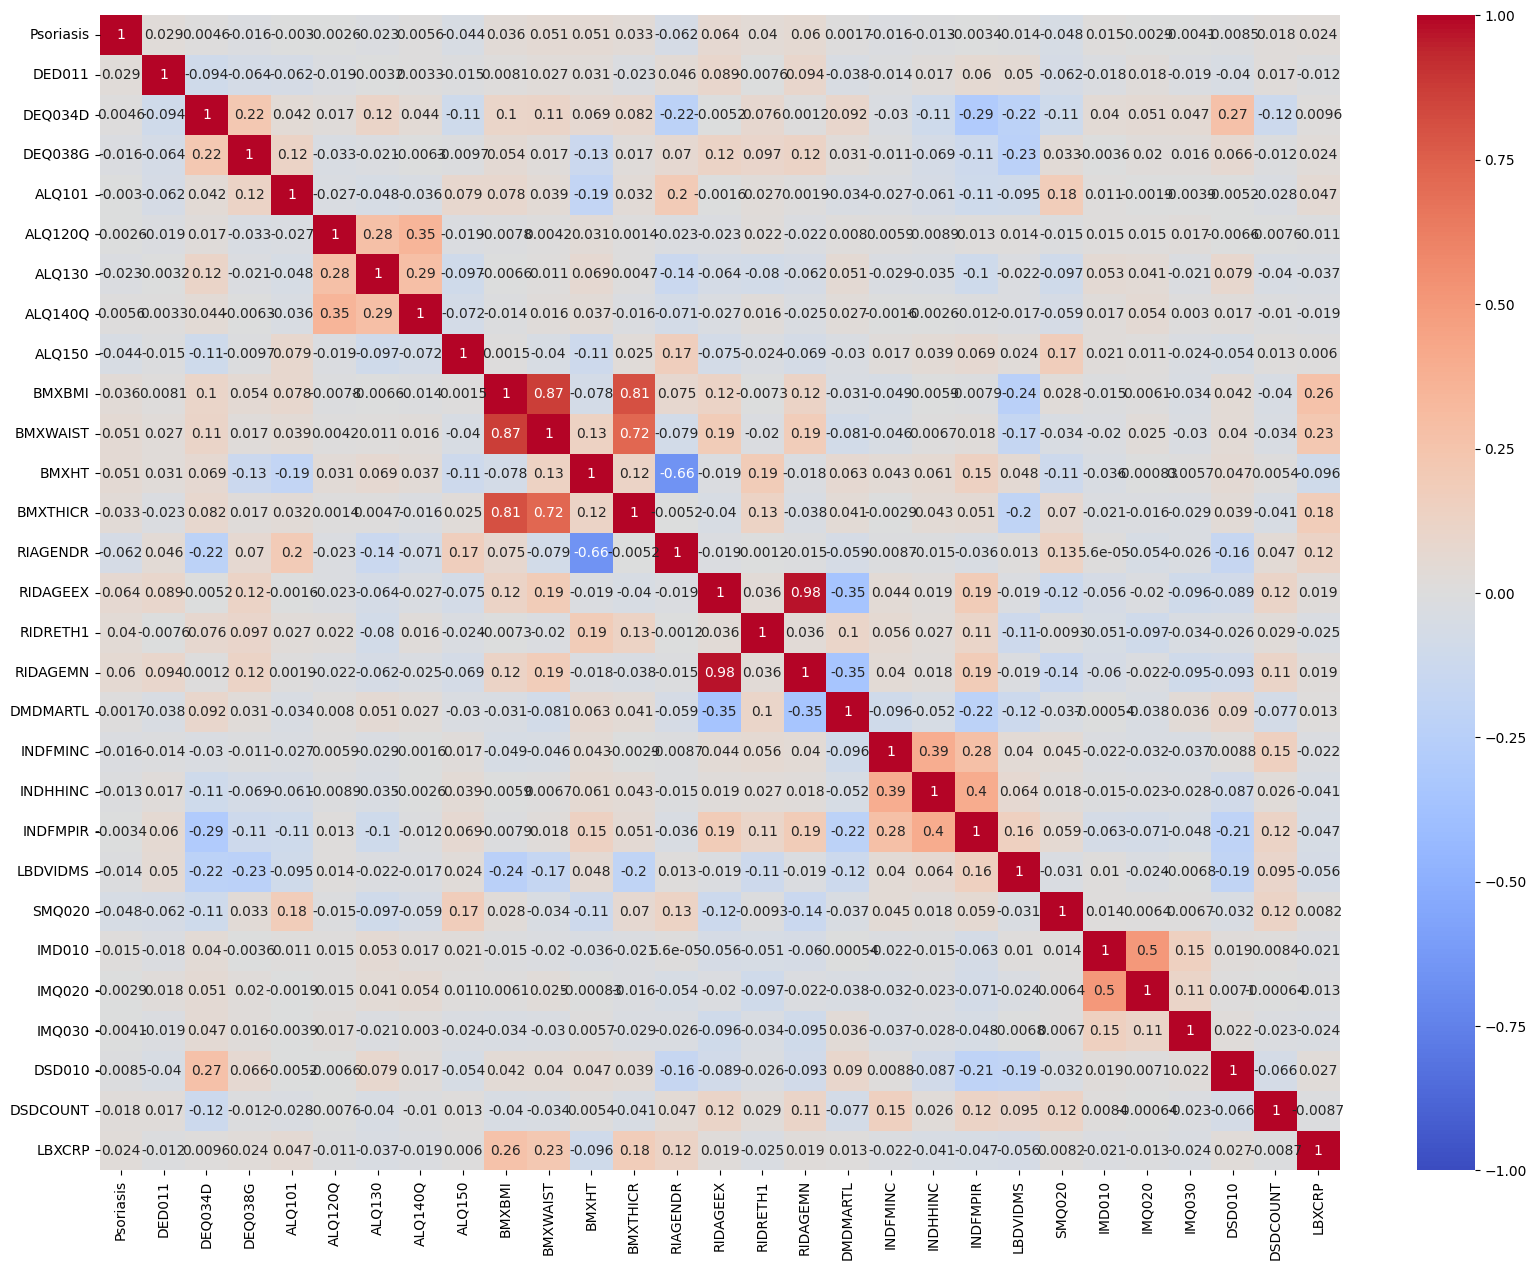

In [ ]:
correlation_matrix1 = df_subset_removena.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix1, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

In [ ]:
df_subset_removena = df_subset_removena.drop('BMXWAIST', axis=1)
df_subset_removena = df_subset_removena.drop('BMXTHICR', axis=1)
df_subset_removena = df_subset_removena.drop('RIDAGEMN', axis=1)

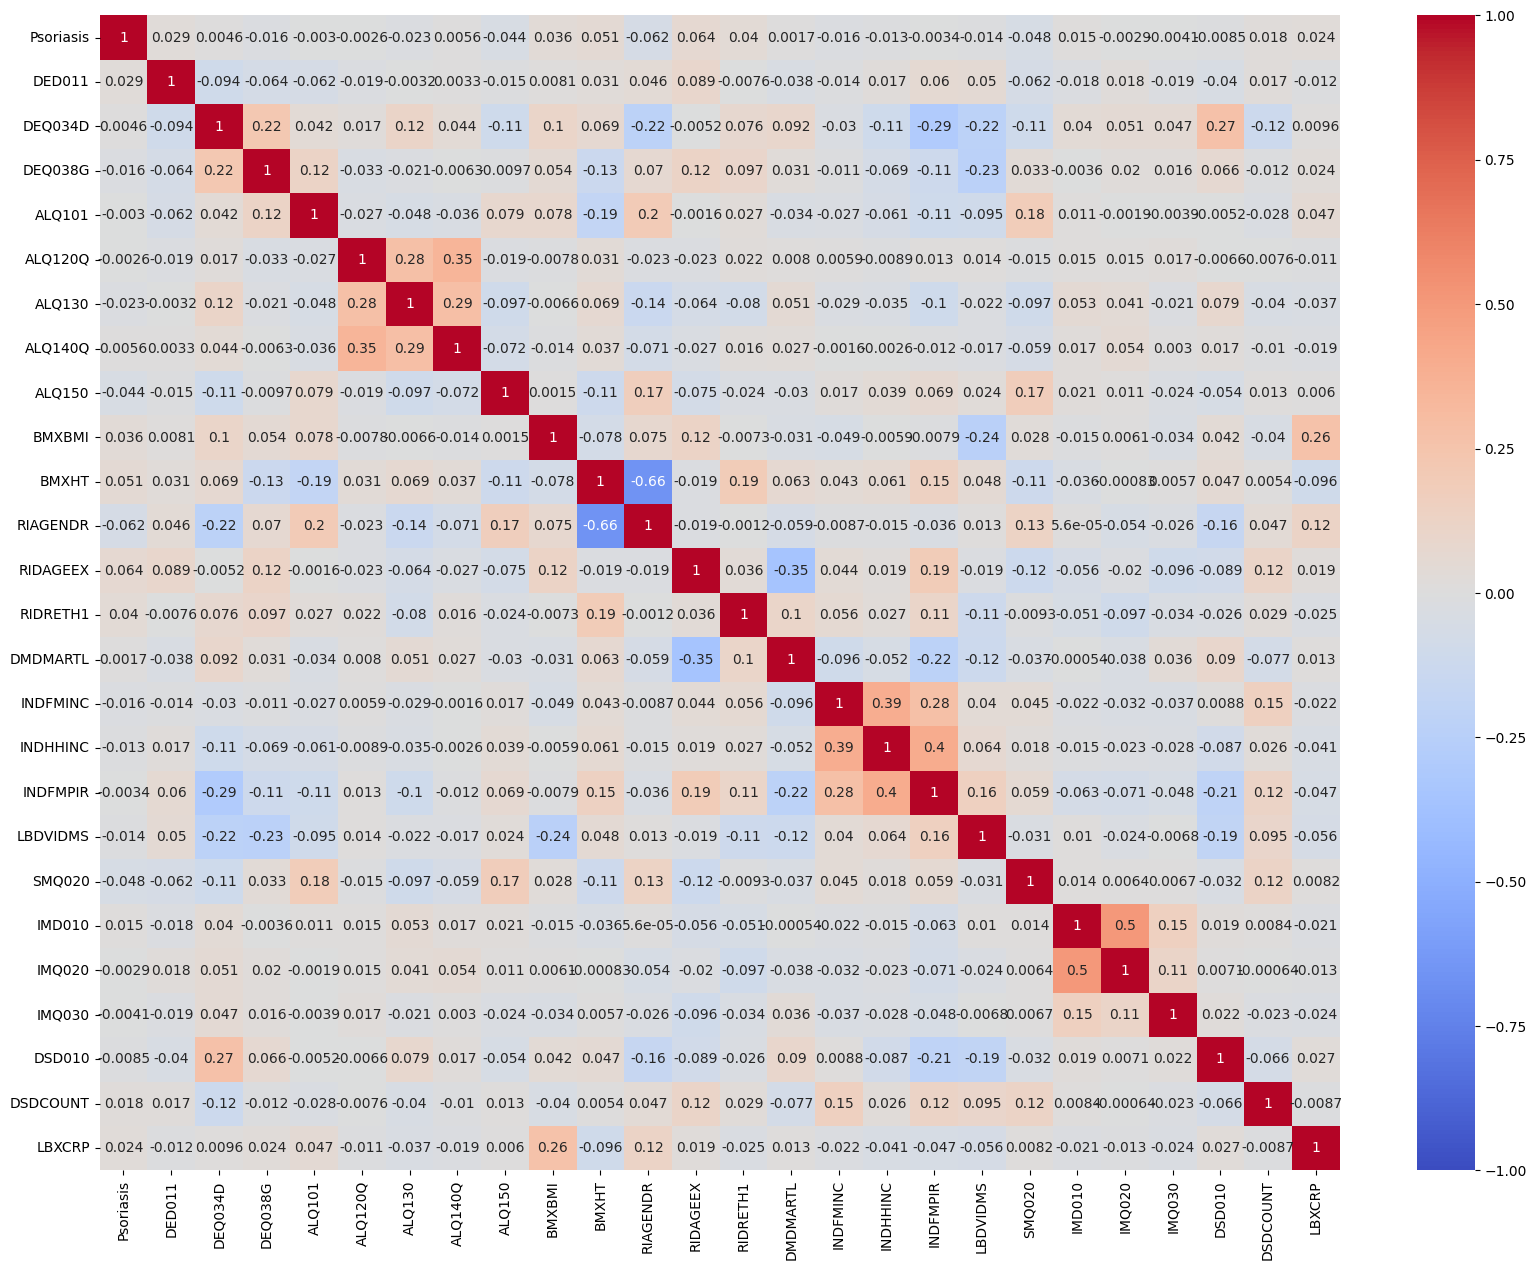

In [ ]:
correlation_matrix = df_subset_removena.corr()
plt.figure(figsize=(20, 15))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.show()

# CLASSIFICATION MODEL

In [ ]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
#df = df_subset_removena.drop(['DEQ053'], axis = 1)
df = df_subset_removena

df_y = df['Psoriasis']
df_x = df.drop(['Psoriasis'], axis = 1)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_x, df_y, test_size=0.3, random_state=42)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)



(2198, 25) (942, 25) (2198,) (942,)


## Logistic Regression (without over sampling or smote)

/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

Best Hyperparameters: {'C': 0.001, 'penalty': 'l1', 'solver': 'liblinear'}
Accuracy: 0.9543524416135881
Confusion Matrix:
[[899   0]
 [ 43   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      1.00      0.98       899
           1       0.00      0.00      0.00        43

    accuracy                           0.95       942
   macro avg       0.48      0.50      0.49       942
weighted avg       0.91      0.95      0.93       942



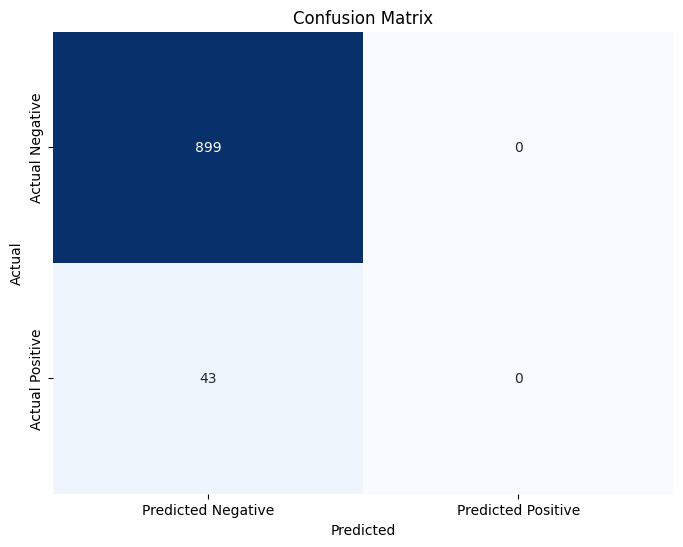

In [ ]:

warnings.filterwarnings("ignore", category=ConvergenceWarning)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
}


logistic_regression = LogisticRegression()


grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train, y_train)


best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_report_str)

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Logistic Regression with Over Sampling and SMOTE

In [ ]:
!pip install -U imbalanced-learn


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 235.6/235.6 kB 4.7 MB/s eta 0:00:00
  Attempting uninstall: imbalanced-learn
    Found existing installation: imbalanced-learn 0.10.1
    Uninstalling imbalanced-learn-0.10.1:
      Successfully uninstalled imbalanced-learn-0.10.1


/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 200.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
25 fits failed with the following error:
Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 1162, in fit
    solver = _check_solver(self.solver, self.penalty, self.dual)
  File "/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py", line 54, in _check_solver
    raise ValueError(
ValueError: Solv

Best Hyperparameters: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
Accuracy: 0.6273885350318471
Confusion Matrix:
[[568 331]
 [ 20  23]]
Classification Report:
              precision    recall  f1-score   support

           0       0.97      0.63      0.76       899
           1       0.06      0.53      0.12        43

    accuracy                           0.63       942
   macro avg       0.52      0.58      0.44       942
weighted avg       0.92      0.63      0.73       942



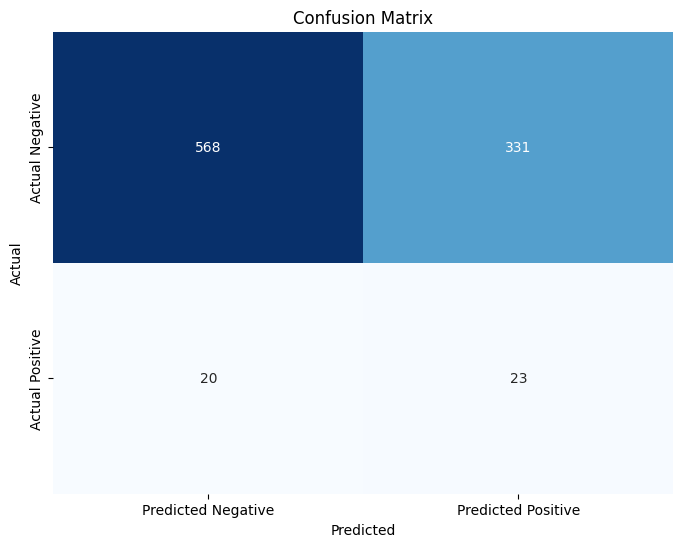

In [ ]:
oversampler = RandomOverSampler(sampling_strategy='auto', random_state=42)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

warnings.filterwarnings("ignore", category=ConvergenceWarning)

param_grid = {
    'C': [0.001, 0.01, 0.1, 1, 10],
    'penalty': ['l1', 'l2'],
    'solver': ['liblinear', 'lbfgs', 'saga', 'newton-cg'],
}

logistic_regression = LogisticRegression()


grid_search = GridSearchCV(estimator=logistic_regression, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train_resampled, y_train_resampled)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)


print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_report_str)


confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


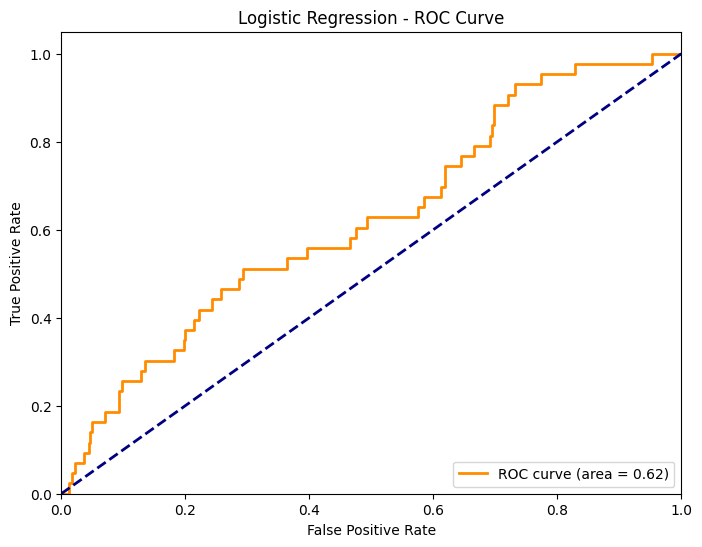

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_scores = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)


plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression - ROC Curve')
plt.legend(loc='lower right')
plt.show()

## XGBoost without oversampling

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

Best Hyperparameters: {'learning_rate': 0.01, 'max_depth': 4, 'min_child_weight': 1, 'n_estimators': 100}
Accuracy: 0.9543524416135881


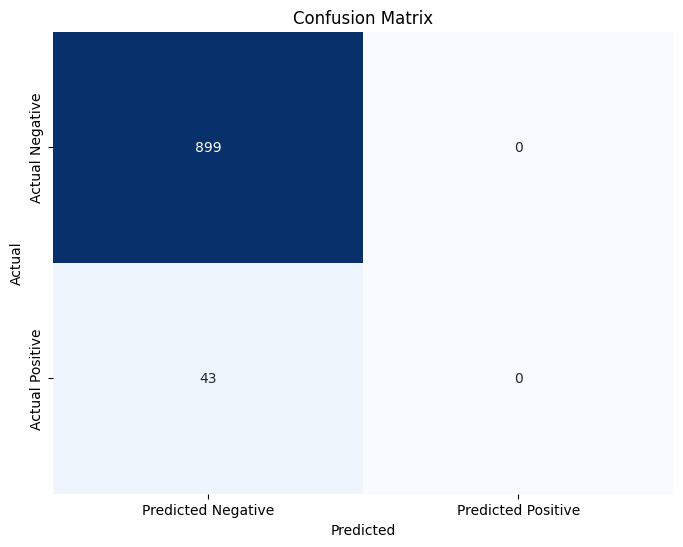

In [ ]:

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 2, 3],


xgb_classifier = xgb.XGBClassifier()

grid_search = GridSearchCV(estimator = xgb_classifier, param_grid=param_grid, scoring='precision', cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()


In [ ]:
xgb_classifier = xgb.XGBClassifier()

xgb_classifier.fit(X_train, y_train)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=1)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)

xgb_classifier.fit(X_train_resampled, y_train_resampled)

y_pred = xgb_classifier.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

Accuracy: 0.9532908704883227
Accuracy: 0.9501061571125266


## XGBoost with OverSamplling

Best Hyperparameters: {'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 1, 'n_estimators': 300}
Accuracy: 0.945859872611465


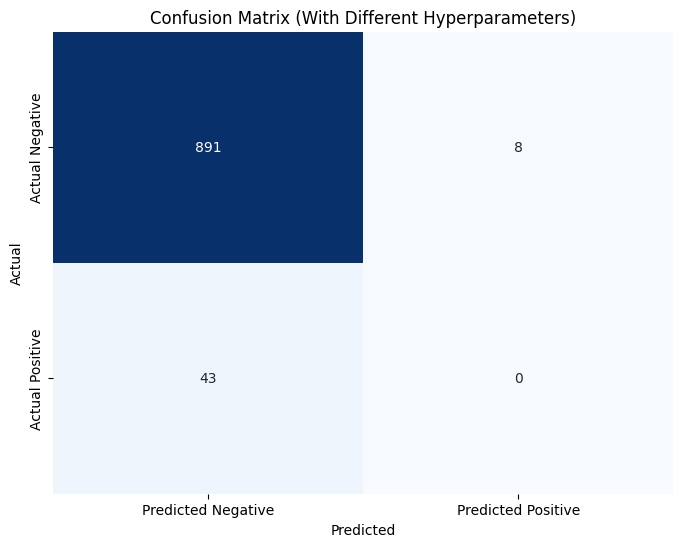

In [ ]:

oversampler = RandomOverSampler(sampling_strategy='auto', random_state=12)
X_train_resampled, y_train_resampled = oversampler.fit_resample(X_train, y_train)


param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [4, 5, 6],
    'min_child_weight': [1, 2, 3],
}


xgb_classifier = xgb.XGBClassifier()


grid_search = GridSearchCV(estimator=xgb_classifier, param_grid=param_grid, scoring='accuracy', cv=5)

grid_search.fit(X_train_resampled, y_train_resampled)
best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_model = grid_search.best_estimator_

y_pred = best_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

confusion = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Predicted Negative', 'Predicted Positive'],
            yticklabels=['Actual Negative', 'Actual Positive'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (With Different Hyperparameters)')
plt.show()


In [ ]:
accuracy = accuracy_score(y_test, y_pred)
confusion = confusion_matrix(y_test, y_pred)
classification_report_str = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Confusion Matrix:")
print(confusion)
print("Classification Report:")
print(classification_report_str)

Accuracy: 0.945859872611465
Confusion Matrix:
[[891   8]
 [ 43   0]]
Classification Report:
              precision    recall  f1-score   support

           0       0.95      0.99      0.97       899
           1       0.00      0.00      0.00        43

    accuracy                           0.95       942
   macro avg       0.48      0.50      0.49       942
weighted avg       0.91      0.95      0.93       942



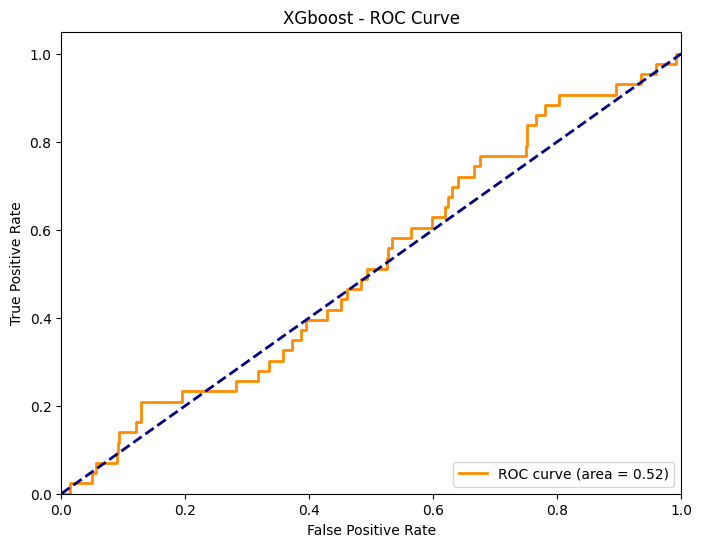

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

y_scores = best_model.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('XGboost - ROC Curve')
plt.legend(loc='lower right')
plt.show()

## RF

In [ ]:
from sklearn.datasets import make_classification
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier

X = df.drop(['Psoriasis'], axis=1)
y = df['Psoriasis']

random_oversampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = random_oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

clf = RandomForestClassifier(random_state=42)

param_grid = {
    'n_estimators': [10, 50, 100],
    'max_depth': [3, 8, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(clf, param_grid, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_clf = RandomForestClassifier(random_state=42, **best_params)
best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

matrix = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:\n", matrix)

Best Hyperparameters: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 10, 'n_estimators': 100}
Accuracy: 0.981651376146789
Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.96      0.98       625
           1       0.96      1.00      0.98       574

    accuracy                           0.98      1199
   macro avg       0.98      0.98      0.98      1199
weighted avg       0.98      0.98      0.98      1199

Confusion Matrix:
 [[603   0]
 [ 22 574]]


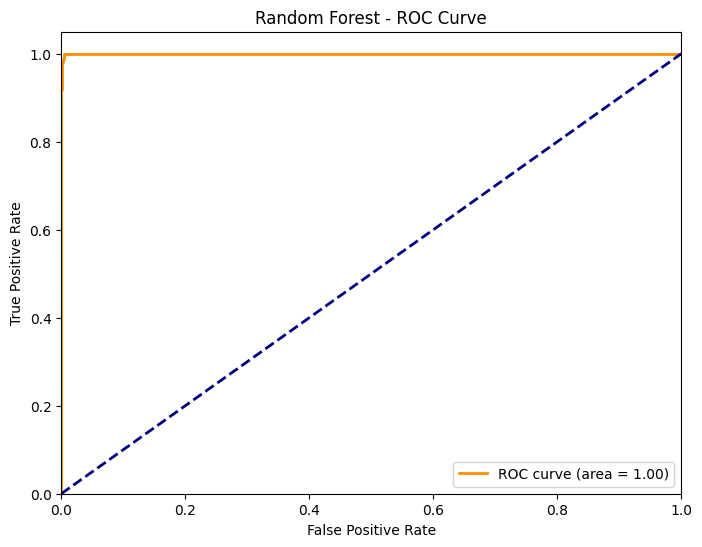

In [ ]:
y_scores = best_clf.predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_test, y_scores)

roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Random Forest - ROC Curve')
plt.legend(loc='lower right')
plt.show()

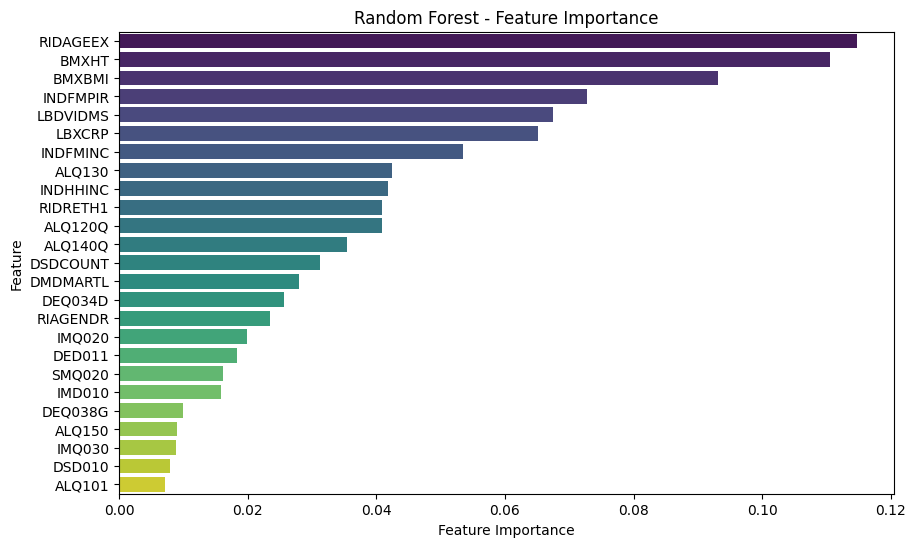

In [ ]:
feature_importances = best_clf.feature_importances_

feature_names = X.columns

feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})

sorted_feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 6))
sns.barplot(x='Importance', y='Feature', data=sorted_feature_importance_df, palette="viridis")
plt.xlabel('Feature Importance')
plt.title('Random Forest - Feature Importance')
plt.show()

## SVM

In [ ]:
from sklearn.svm import SVC
X = df.drop(['Psoriasis'], axis=1)
y = df['Psoriasis']

random_oversampler = RandomOverSampler(random_state=42)

X_resampled, y_resampled = random_oversampler.fit_resample(X, y)

X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.3, random_state=42)

clf = SVC()

param_grid = {
    'kernel': ['linear', 'poly', 'sigmoid']
}

grid_search = GridSearchCV(clf, param_grid, cv=5)

grid_search.fit(X_train, y_train)

best_params = grid_search.best_params_
print("Best Hyperparameters:", best_params)

best_clf = SVC(**best_params)

best_clf.fit(X_train, y_train)

y_pred = best_clf.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)

report = classification_report(y_test, y_pred)
print("Classification Report:\n", report)

matrix = confusion_matrix(y_pred, y_test)
print("Confusion Matrix:\n", matrix)




Best Hyperparameters: {'kernel': 'linear'}
Accuracy: 0.6379310344827587
Classification Report:
               precision    recall  f1-score   support

           0       0.72      0.49      0.58       935
           1       0.59      0.80      0.68       863

    accuracy                           0.64      1798
   macro avg       0.66      0.64      0.63      1798
weighted avg       0.66      0.64      0.63      1798

Confusion Matrix:
 [[458 174]
 [477 689]]


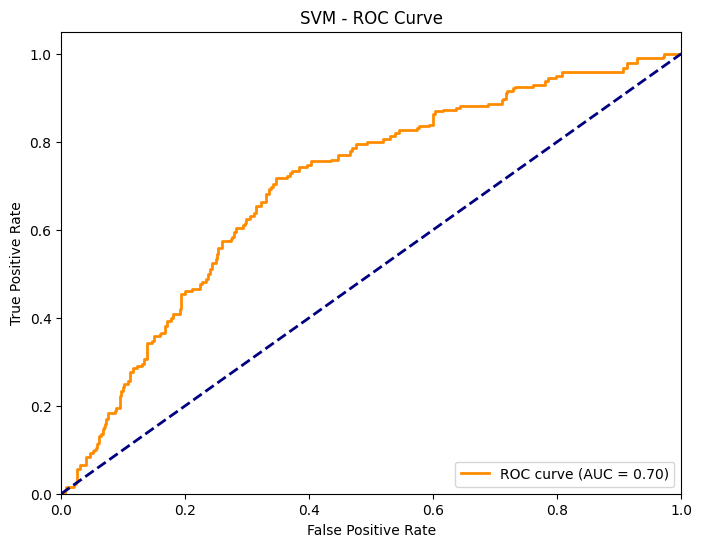

In [ ]:
y_scores = best_clf.decision_function(X_test)

fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('SVM - ROC Curve')
plt.legend(loc='lower right')

plt.show()



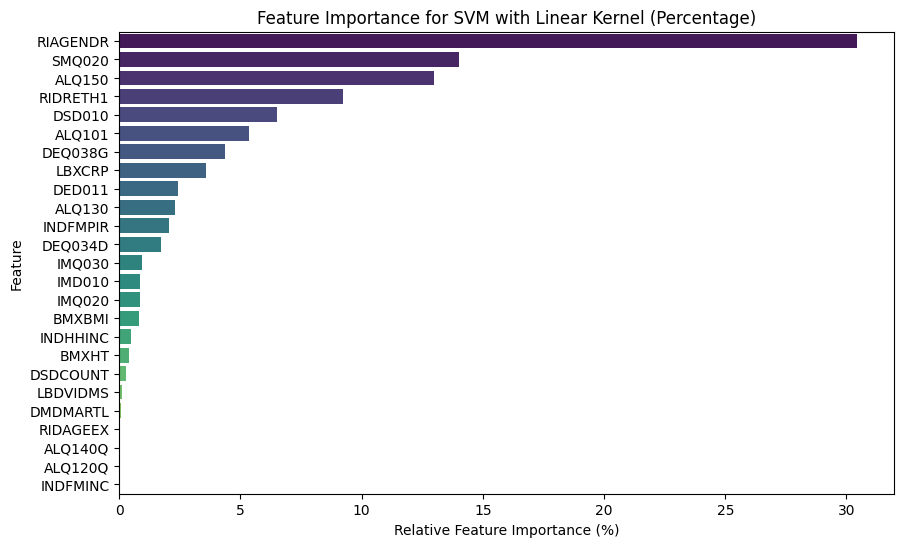

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

if best_clf.kernel == 'linear':
    feature_weights = best_clf.coef_.ravel()
    feature_names = X.columns

    absolute_feature_weights = abs(feature_weights)

    total_absolute_weight = sum(absolute_feature_weights)

    relative_importance = (absolute_feature_weights / total_absolute_weight) * 100

    feature_importance = pd.DataFrame({'Feature': feature_names, 'Relative Importance (%)': relative_importance})

    sorted_feature_importance = feature_importance.sort_values(by='Relative Importance (%)', ascending=False)

    plt.figure(figsize=(10, 6))
    sns.barplot(x='Relative Importance (%)', y='Feature', data=sorted_feature_importance, palette="viridis")
    plt.xlabel('Relative Feature Importance (%)')
    plt.title('Feature Importance for SVM with Linear Kernel (Percentage)')
    plt.show()

else:
    print("Feature importances as percentages are only available for SVM with a linear kernel.")
